# Опис першого завдання

Виконали: Дзвенислава Бутинець, Назар Тхір

Мета завдання: реалізувати алгоритм Прима для знаходження мінімального остовного дерева графа і порівняти його продуктивність з вбудованим алгоритмом.

Опис завдання: знаходження мінімального кісткового дерева - підмножини ребер неорієнтованого зв'язного зваженого графа, яка включає всі вершини, та для якої сума ваг ребер є мінімальною.


Процес дослідження: виконання проекту розпочався з дослідження роботи алгоритму, тобто аналізу псевдокоду. Після розпочалася розробка. Спочатку даний алгоритм був реалізований неоптимально, це було виявлено під час етапу часового порівняння. Тому було знайдено більш ефективний спосіб реалізації.


In [17]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby
from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

## Generating graph

In [20]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(0, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

# Task 1 (Prim's algorithm)

## Алгоритм

input - граф

output - список кортежів, елементами, якого є ребра

Спочатку ми формуємо два списки - ребер та вершин, відвідуваних вершин(visited). Set visited перед початком роботи алгоритму визначений як 0(початкова вершина). Після цього ми сортуємо список ребер за вагою у порядку зростання, це потрібно для того аби в майбутньому знаходити інцидентні ребра до пройдених вершин і витягувати їх із списку таке ребро з найменшою вагою. Тоді ми запускаємо цикл, який буде складатися з nodes-1 ітерацій(де nodes - це список вершин). Для кожного ребра, я перевіряю дві умови - інцидентність до відвіданих вершин та наявність циклу. Якщо таке ребро виявлене воно додається до списку minimum_tree.




In [81]:
G = gnp_random_connected_graph(10, 1, False, False)

In [82]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

In [83]:
def prims_algorytms(graph: list[tuple]) -> list:
    """
    Algorytm which finds minimum spanning tree.
    """
    nodes = graph.nodes()
    edges = sorted(graph.edges(data=True), key= lambda x: x[2]["weight"])
    graph.edges(data = True)
    minimum_tree = []
    visited = {0}
    for i in range(len(nodes) - 1):
        for edge in edges:
            if (edge[0] in visited and not edge[1] in visited) or (edge[1] in visited and not edge[0] in visited):
                minimum_tree.append((edge[0], edge[1]))
                visited.update((edge[0], edge[1]))
                edges.remove(edge)
                break
    return minimum_tree
prims_algorytms(gnp_random_connected_graph(10, 0.5, False))

[(0, 2), (2, 6), (6, 8), (6, 7), (1, 6), (7, 9), (0, 4), (2, 3), (5, 7)]

In [88]:
def timer_our(n):
    NUM_OF_ITERATIONS = 1000
    time_taken = 0
    for i in range(NUM_OF_ITERATIONS):

        # note that we should not measure time of graph creation
        G = gnp_random_connected_graph(n, 0.5, False, False)

        start = time.time()
        try:
            prims_algorytms(G)
        except:
            continue
        end = time.time()

        time_taken += end - start

        return (time_taken / NUM_OF_ITERATIONS)
    
def timer_ntwx(n):
    NUM_OF_ITERATIONS = 1000
    time_taken = 0
    for i in range(NUM_OF_ITERATIONS):

        # note that we should not measure time of graph creation
        G = gnp_random_connected_graph(n, 0.5, False, False)

        start = time.time()
        try:
            tree.minimum_spanning_tree(G, algorithm="prim")
        except:
            continue
        end = time.time()

        time_taken += end - start

        return (time_taken / NUM_OF_ITERATIONS)

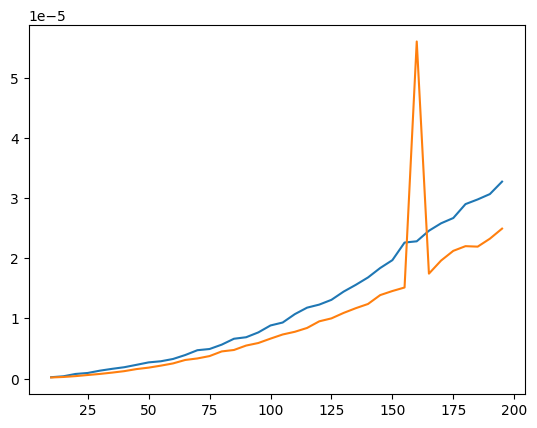

In [94]:
x = [n for n in range(10, 200, 5)]
y_our = [timer_our(n) for n in x]
y_ntwx = [timer_ntwx(n) for n in x]
plt.plot(x,y_our)
plt.plot(x,y_ntwx)
plt.show()

Синій - наш, оранжевий - вбудований.

# Task 2 (Bellman-Ford algorithm)

## Алгоритм

input - граф

output - масив з точками через які ми добирались, масив з відстаннями

Алгоритм написаний по псевдокоду. Для швидкості використано бібліотеку numpy.


In [24]:
G = gnp_random_connected_graph(10, 0.5, True, False)


In [27]:
import numpy as np

def new_bellman(G, source):
    edges = list(G.edges()(data=True))
    nodes = list(G.nodes())
    if source not in nodes:
        raise KeyError(f"Node {source} is not in the graph.")
    dist = np.zeros((len(nodes)+1, len(nodes)))
    pred = np.zeros((len(nodes)))
    pred[:] = float('inf')
    for i in range(len(nodes)):
        dist[0,:] = float('inf')
    pred[0] = 0
    dist[0,source] = 0
    for i in range(1, len(nodes)+1):
        dist[i,:] = dist[i-1,:]
        for u, v, w in edges:
            if dist[i,v] > dist[i-1,u] + w['weight']:
                dist[i,v] = dist[i-1,u] + w['weight']
                pred[v] = u
        if (dist[i-1,:] == dist[i,:]).all():
            return dist[i,:], pred
    raise ValueError(f'Negative cycle detected')
new_bellman(G, 0)

(array([ 0., 11., inf,  0.,  2., 11.,  8.,  5.,  3., 12.]),
 array([ 0.,  0., inf,  0.,  0.,  4.,  4.,  3.,  3.,  8.]))

In [87]:
def timer_our(n):
    NUM_OF_ITERATIONS = 1000
    time_taken = 0
    for i in range(NUM_OF_ITERATIONS):

        # note that we should not measure time of graph creation
        G = gnp_random_connected_graph(n, 0.5, True, False)

        start = time.time()
        try:
            new_bellman(G, 0)
        except:
            continue
        end = time.time()

        time_taken += end - start

        return (time_taken / NUM_OF_ITERATIONS)
    
def timer_ntwx(n):
    NUM_OF_ITERATIONS = 1000
    time_taken = 0
    for i in range(NUM_OF_ITERATIONS):

        # note that we should not measure time of graph creation
        G = gnp_random_connected_graph(n, 0.5, True, False)

        start = time.time()
        try:
            bellman_ford_predecessor_and_distance(G, 0)
        except:
            continue
        end = time.time()

        time_taken += end - start

        return (time_taken / NUM_OF_ITERATIONS)

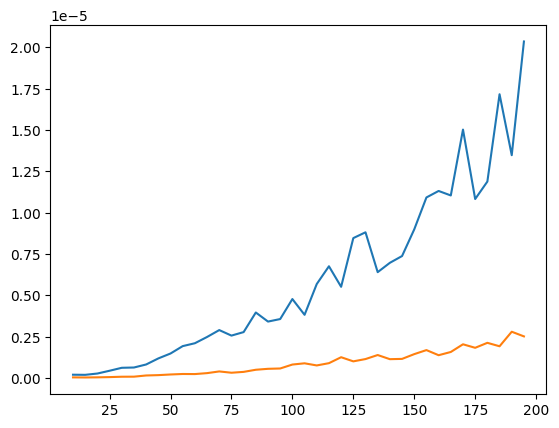

In [76]:
x = [n for n in range(10, 200, 5)]
y_our = [timer_our(n) for n in x]
y_ntwx = [timer_ntwx(n) for n in x]
plt.plot(x,y_our)
plt.plot(x,y_ntwx)
plt.show()

Синій - наш, оранжевий - вбудований.

# Висновок

Обидва алгоритми працюють чудовов. Але, очевидно, що зі збільшенням кількості вершин в графі час виконання алгоритму теж зростає. Час можна було б покращити оптимізацією алгоритму. 